# Modelo *RMFT* ($\sigma$-$\omega$) con Autointeracción del Campo Escalar

In [1]:
# Importamos las librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 3
from scipy.interpolate import CubicSpline

import scripts.AutointeractuanteEoS as AIEoS
import scripts.ResolverTOV as tov

## Ecuacion de Estado del Modelo

### Ecuaciones de la teoría

Habiendo definido los términos de autointeracción del campo escalar en unidades naturales $c=\hbar=1$

$$U(\sigma) = \frac{1}{3}bm(g_\sigma\sigma)^3+\frac{1}{4}c(g_\sigma\sigma)^4,$$

podemos escribir las ecuaciones de autoconsistencia, energía y presión empleando las variables y parámetros adimensionales $\tilde x_{\sigma} = 1-g_{\sigma}\sigma/m$, $\tilde n = n/m^3$, $x = p/m$, $\tilde A_{\sigma} = (g_\sigma/m_\sigma)^2m^2$, $\tilde A_{\omega} = (g_\omega/m_\omega)^2m^2$; y la constante $\lambda = m^4$ con unidades de densidad de energía $\text{MeV/fm}^3$ o equivalentemente $\text{fm}^{-4}$

$$ (1-\tilde x_{\sigma}) - \tilde A_{\sigma}\left[\frac{2}{\pi^2} \int_0^{x_F(n)} \frac{\tilde x_{\sigma} x^2 dx}{\sqrt{x^2 + \tilde x_{\sigma}^2}} - b (1-\tilde x_{\sigma})^2 - c (1-\tilde x_{\sigma})^3\right] = 0$$
$$ \tilde\rho = \frac{\lambda}{2\rho_0} \left[(1-\tilde x_{\sigma})^2\left(\frac{1}{\tilde A_{\sigma}} + \frac{2}{3} b(1-\tilde x_{\sigma}) + \frac{1}{2} c(1-\tilde x_{\sigma})^2\right) + \tilde A_{\omega}^2 \tilde n^2 + \frac{4}{\pi^2} \int_0^{x_F(n)} x^2 \sqrt{x^2 + \tilde x_{\sigma}^2} dx\right]$$
$$ \tilde P = \frac{\lambda}{2\rho_0} \left[-(1-\tilde x_{\sigma})^2\left(\frac{1}{\tilde A_{\sigma}} + \frac{2}{3} b(1-\tilde x_{\sigma}) + \frac{1}{2} c(1-\tilde x_{\sigma})^2\right) + \tilde A_{\omega}^2 \tilde n^2 + \frac{4}{3\pi^2} \int_0^{x_F(n)} \frac{x^4}{\sqrt{x^2 + \tilde x_{\sigma}^2}} dx\right]$$

### Ecuación de estado numérica

In [4]:
# Definimos las constantes necesarias en MKS
hbar_MKS = 1.0545718e-34 # J s
c_MKS = 299792458 # m/s
G_MKS = 6.67430e-11 # m^3/kg/s^2
pi = np.pi
proton_mass = 1.6726219e-27 # kg
neutron_mass = 1.6749275e-27 # kg
m_nuc_MKS = (proton_mass + neutron_mass)/2.0 # kg
e_MKS = 1.602186021766e-19 # C

# Algunas converciones útiles (multiplicar al primero para obtener el segundo)
Kg_to_fm11 = c_MKS/hbar_MKS*1e-15 # kg to fm^-1
MeV_to_fm11 = e_MKS/(hbar_MKS*c_MKS*1e9) # MeV to fm^-1
MeVfm_to_Jm  = 1e51*e_MKS # MeV/fm to J/m

# Definimos las constantes necesarias en unidades naturales
m_nuc = m_nuc_MKS * Kg_to_fm11 # fm^-1
lambda_ = m_nuc**4 # Constante de escala empleada
rho_0_lambda = lambda_/2 # Escala de energía y presión empleada

# Damos valores a las constantes (fijadas con n_sat y (B/A)_sat) (constantes tilde cuadradas)
# A_sigma = 330.263 # Walecka: 266.9, 357.4
# A_omega = 249.547 # Walecka: 195.7, 273.8
# b = 5e-4
# c = 5e-4
# Optimizados con lmfit
A_sigma = 336.839496
A_omega = 249.482170
b = 3.656607e-04
c = -6.686167e-04

#Boguta - Bormer
# A_sigma = 16.34**2
# A_omega = 13.99**2
# b=c=0

params = [A_sigma, A_omega, b, c]

# Calculamos si no hay archivo de la EoS, si no, lo leemos
operacion = 'calc' # 'calc' o 'leer'

if operacion == 'calc':
    # Definimos el rango de densidades para la interpolación de la EoS
    densidad_masa_max = 1e18*1e3*(1e-45/m_nuc_MKS) # g/cm^3 a kg/m^3 a 1/fm^3
    densidad_masa_min = 1e10*1e3*(1e-45/m_nuc_MKS) # g/cm^3 a kg/m^3 a 1/fm^3
    n_barions = np.logspace(np.log10(densidad_masa_min), np.log10(densidad_masa_max), 200)
    # Calculamos la EoS
    rho_P, presiones, energias, n_sirve, presion_cambio = AIEoS.EoS(n_barions, params)
    df = pd.DataFrame({'n': n_sirve[presion_cambio:], 'P': presiones[presion_cambio:], 'E': energias[presion_cambio:]})
    df.to_csv('EoS_tables/SigmaOmegaAuto_rho0_lambda_A_propios.csv', index=False, float_format='%.15e')
elif operacion == 'leer':
    # Leemos los resultados de la EoS
    df = pd.read_csv('EoS_tables/SigmaOmegaAuto_rho0_lambda_A_propios.csv')
    n_sirve = df['n'].values
    presiones = df['P'].values
    energias = df['E'].values
    rho_P = CubicSpline(presiones, energias)
    presion_cambio = False

## Solución de las Ecuaciones Hidrostáticas

In [ ]:
# Si la variable presion_cambio no es false, redefinimos los arrays
if presion_cambio:
    # Definimos la densidad de bariones y la presión para la integración del sistema
    n_sirve = n_sirve[presion_cambio:]
    presiones = presiones[presion_cambio:]
    energias = energias[presion_cambio:]
    rho_P = CubicSpline(presiones, energias)

# Definimos la ecuacion de estado para la integración del sistema
print("Primer densidad de barinoes util", "{:2.2e}".format(n_sirve[0]), "1/fm^3 por ende densidad de masa", format(n_sirve[0]*1e45*m_nuc_MKS*1e-3,"2.2e"), "g/cm^3 y presión", format(presiones[0], "2.2e"), "adimensional")
densidad_limite = energias[0] # Densidad de energia límite adimensional para rho_0 = lambda/2
P_rho = CubicSpline(energias, presiones) # Presión en función de la densidad de energía para rho_0 = lambda/2
P_central = P_rho(1) # Presión central en unidades adimensionales para rho_0 = lambda/2

# Definimos los parametros de integración
rf = 20 # Radio final adimensional
dr = 1e-3 # Paso de integración adimensional

# Resolvemos el sistema TOV
rho_nat_to_MKS = 1.0 / MeV_to_fm11 * MeVfm_to_Jm
sol_final = tov.integrador(rf, dr, rho_0_lambda*rho_nat_to_MKS, rho_P, P_central, densidad_limite=densidad_limite)
# Orden: r, m, rho, P, phi
print("Radio final = ", sol_final[0]/1e3, "km, Masa final = ", sol_final[1]/1.989e30, "M_sun")
# tov.graficar_solucion(rf, dr, rho_0_lambda, rho_P, P_central, densidad_limite=densidad_limite)

Primer densidad de barinoes util 1.09e-01 1/fm^3 por ende densidad de masa 1.83e+14 g/cm^3 y presión 2.20e-08 adimensional
Radio final =  10.791070621395043 km, Masa final =  2.1499946938720473 M_sun


Masa máxima: 2.984 M_sun para rho0_m = 1.050e+15 g/cm^3


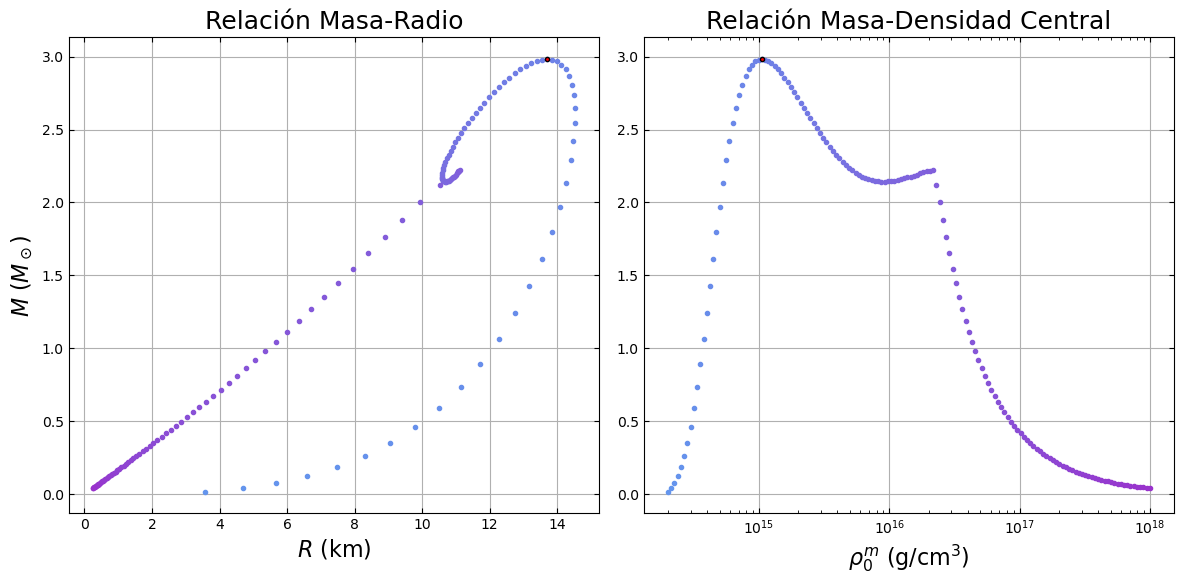

In [ ]:
# Definimos el espacio de densidades centrales de masa para la integración
rhos_masa = np.logspace(np.log10(n_sirve[1]*1e45*m_nuc_MKS*1e-3), 18, 150) # Densidades de masa en kg/m^3 (desde donde es util la EoS)
# rhos_masa = np.logspace(14, 18, 100) # Densidades de masa en kg/m^3

# Calculamos la densidad de energía asociada a cada densidad de masa
rhos = []
for rho_m in rhos_masa:
    densidad_energia, _ = AIEoS.energia_presion(rho_m*1e3/m_nuc_MKS*1e-45, params)
    rhos.append(densidad_energia)
    
# Definimos arrays para la masa y el radio
masas = np.zeros(len(rhos))
radios = np.zeros(len(rhos))

# Resolvemos el sistema TOV para cada densidad central de masa
arg_max = 0
for i in range(len(rhos)):
    rho0 = rhos[i] # Densidad de energía central adimensionalizada con rho_0_lambda
    R = 1.0/rho0 # Factor de conversión para la interpolación adimensionalizada con rho0
    rho_P_prima = lambda P: R*rho_P(P/R) # Interpolación adimensionalizada con rho0 (en función de P adimensional con rho0)
    P_central_prima = R*P_rho(1/R) # Presión central adimensionalizada con rho0
    densidad_limite_prima = R*densidad_limite # Densidad de energía límite adimensionalizada con rho0
    sol_final = tov.integrador(rf, dr, rho0*rho_0_lambda*rho_nat_to_MKS, rho_P_prima, P_central_prima, densidad_limite=densidad_limite_prima)
    radios[i] = sol_final[0] # Radio final en metros
    masas[i] = sol_final[1] # Masa final en kg
    if masas[i] > masas[arg_max]:
        arg_max = i
    # print("Se pudo para densidad de masa =", format(rho_m,"2.2e"), "g/cm^3")
    
# Guardamos los resultados en un archivo MasaRadio_SigmaOmegaAuto_rho0_lambda_A_propios.csv
m_sun = 1.989e30 # kg
df = pd.DataFrame({'Masa': masas/m_sun, 'Radio': radios*1e-3, 'rho_m': rhos_masa})
df.to_csv('results/MasaRadio_SigmaOmegaAuto_rho0_lambda_A_propios.csv', index=False, float_format='%.15e')
    
# Graficamos la relación masa-radio
tov.grafica_masa_radio(radios, masas, rhos_masa)

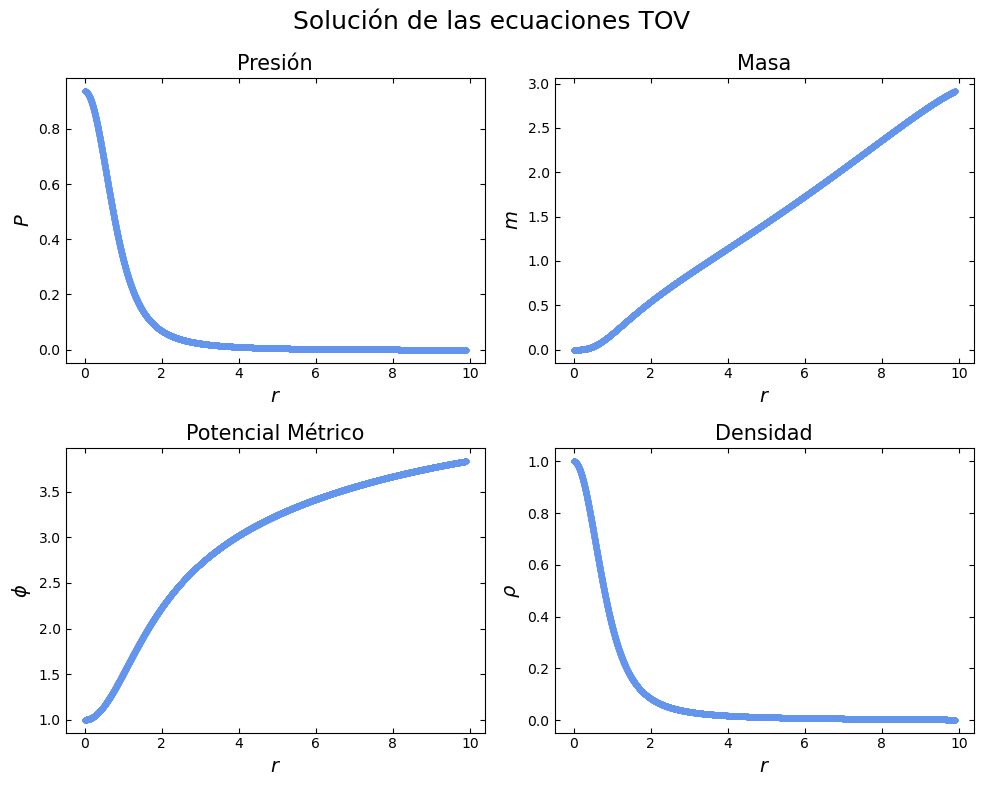

In [21]:
tov.graficar_solucion(rf, dr, rho_0_lambda*rho_nat_to_MKS, rho_P, P_central, densidad_limite=densidad_limite)

## Resultados de la EoS

### Ecuación de autoconsistencia

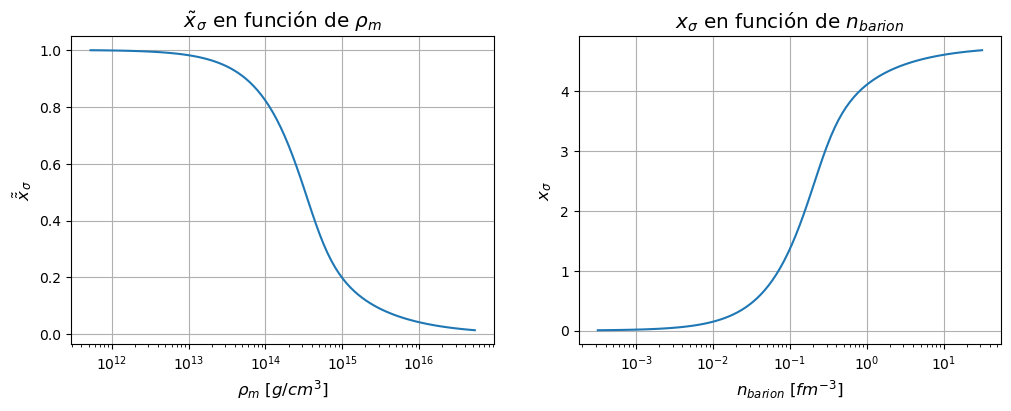

In [ ]:
# Testeamos la solucion_x_sigma
n_prove = np.logspace(-3.5, 1.5, 100) 
AIEoS.plot_autoconsistencia(n_prove, params)

### Interpolación y ecuación de estado

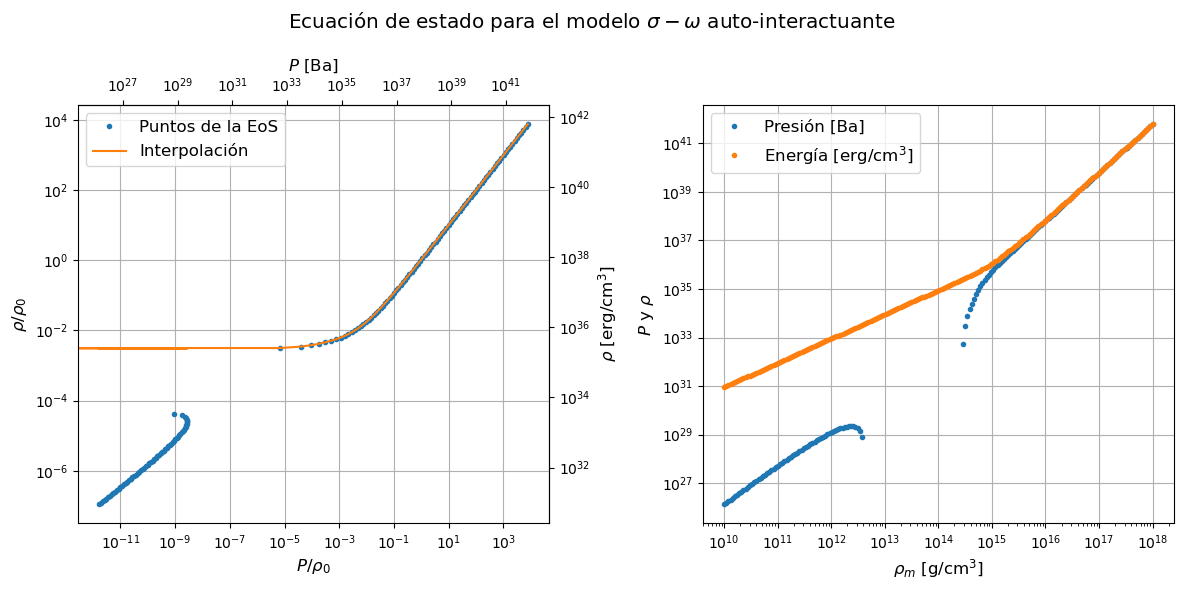

In [5]:
AIEoS.plot_EoS(rho_P, presiones, energias, n_sirve, titulo=r'Ecuación de estado para el modelo $\sigma-\omega$ auto-interactuante')

### Observables $\frac{B}{A}$, $n_{sat}$, $K_{sat}$ y $a_{sym}$

La masa efectiva en saturación es: 0.518 m_nuc
Densidad de saturación n_saturacion = 0.169 1/fm^3 ( 2.822e+14 g/cm^3 ) y energia de enlace por nucleon en saturación = -17.543 MeV y densidad de energia en saturación = 155.338 MeV/fm^3
Presion en la densidad de saturación: 2.3238535880630508e+30 Pa


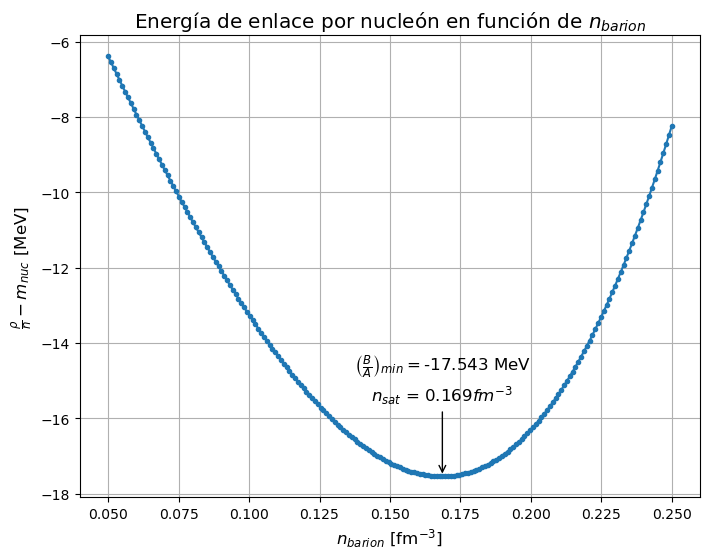

In [6]:
# Graficamos la energia de enlace por nucleon vs la densidad de bariones
# n_prove = np.logspace(-3, -0.5, 200) # Densidades de bariones en fm^-3
n_prove = np.linspace(5e-2, 0.25, 200) # Densidades de bariones en fm^-3
AIEoS.plot_saturacion(n_prove, params)

In [7]:
# Calculamos la saturacion de la EoS
saturacion = AIEoS.plot_saturacion(n_prove, params, plot=False)

# Calculamos el modulo de compresion y el coeficiente de energía de simetría
K = AIEoS.modulo_compresion(saturacion[0], [A_sigma, A_omega, b, c])
print(f'Modulo de compresion: {K:.4f} MeV')

a_sym = AIEoS.coeficiente_simetria(saturacion[0], [A_sigma, A_omega, b, c])
print(f'Coeficiente de simetria: {a_sym:.4f} MeV')

Modulo de compresion: 580.8088 MeV
Coeficiente de simetria: 21.5204 MeV


### Estimación de los parámetros $\tilde{A}_{\sigma}$, $\tilde{A}_{\omega}$, $\tilde{b}$ y $\tilde{c}$ a partir de $\frac{B}{A}$, $n_{sat}$, $K_{sat}$ y $a_{sym}$ 

In [8]:
from lmfit import minimize, create_params, report_fit

# Valores conocidos de las propiedades nucleares
n_saturacion_0 = 0.161               # fm^-3
binding_energy_0 = -16.24            # MeV
compression_modulus_0 = 230.0        # MeV
energy_symmetry_coefficient_0 = 31.6 # MeV
known_values = np.array([n_saturacion_0, binding_energy_0, compression_modulus_0, energy_symmetry_coefficient_0])

# Función residual para lmfit
def residual(params, n_barions, known_values):
    param_vector = [params['A_sigma'].value, params['A_omega'].value, params['b'].value, params['c'].value]
    calculated_values = AIEoS.calculate_properties(n_barions, param_vector)
    return calculated_values - known_values

# Definimos el rango de densidades para buscar saturación
n_prove = np.logspace(-2, 1, 100)  # m^-3

# Utilizamos create_params de lmfit para definir los parámetros
params_lm = create_params(A_sigma={'value':A_sigma, 'min':100, 'max':400},
                         A_omega={'value':A_omega, 'min':100, 'max':400},
                            b={'value':b, 'min':-5e-2, 'max':5e-2},
                            c={'value':c, 'min':-5e-2, 'max':5e-2})

result = minimize(residual, params_lm, args=(n_prove, known_values), method='least-squares', tol=1e-8)

# Extraemos los parámetros optimizados y calculamos las propiedades nucleares
opt_params = result.params
optimized_vector = [opt_params['A_sigma'].value, opt_params['A_omega'].value, opt_params['b'].value, opt_params['c'].value]
optimized_properties = AIEoS.calculate_properties(n_prove, optimized_vector)
optimized_residuals = result.residual

print("Estado de terminación:", result.message)
print("Parámetros óptimos:")
print(f"A_sigma = {opt_params['A_sigma'].value:.6f}")
print(f"A_omega = {opt_params['A_omega'].value:.6f}")
print(f"b = {opt_params['b'].value:.6e}")
print(f"c = {opt_params['c'].value:.6e}")

print("\nPropiedades nucleares:")
print(f"Densidad de saturación: {optimized_properties[0]:.3f} fm^-3 -> error: {optimized_residuals[0]:.3f} fm^-3")
print(f"Energía de enlace por nucleón: {optimized_properties[1]:.3f} MeV -> error: {optimized_residuals[1]:.3f} MeV")
print(f"Módulo de compresión: {optimized_properties[2]:.3f} MeV -> error: {optimized_residuals[2]:.3f} MeV")
print(f"Coeficiente de energía de simetría: {optimized_properties[3]:.3f} MeV -> error: {optimized_residuals[3]:.3f} MeV")

Estado de terminación: Optimization terminated successfully.
Parámetros óptimos:
A_sigma = 316.210977
A_omega = 247.904975
b = 4.875980e-04
c = -1.239776e-03

Propiedades nucleares:
Densidad de saturación: 0.152 fm^-3 -> error: -0.009 fm^-3
Energía de enlace por nucleón: -7.462 MeV -> error: 8.778 MeV
Módulo de compresión: 230.268 MeV -> error: 0.268 MeV
Coeficiente de energía de simetría: 18.511 MeV -> error: -13.089 MeV


In [ ]:
from lmfit import minimize, create_params, report_fit
import numpy as np

# Valores conocidos de las propiedades nucleares
n_saturacion_0 = 0.161               # fm^-3
binding_energy_0 = -16.24            # MeV
compression_modulus_0 = 230.0        # MeV
energy_symmetry_coefficient_0 = 31.6 # MeV
known_values = np.array([n_saturacion_0, binding_energy_0, compression_modulus_0, energy_symmetry_coefficient_0])

# Función residual para lmfit
def residual(params, n_barions, known_values):
    param_vector = [params['A_sigma'].value, params['A_omega'].value,
                    params['b'].value, params['c'].value]
    calculated_values = AIEoS.calculate_properties(n_barions, param_vector)
    return calculated_values - known_values

# Rango de densidades (en m^-3)
n_prove = np.logspace(-2, 1, 100)

# Parámetros iniciales (guess inicial)
current_guess = [A_sigma, A_omega, b, c]

n_iter = 5
error_list = []

print("Iterando optimización:")
for i in range(n_iter):
    params_lm = create_params(
        A_sigma={'value': current_guess[0], 'min':100, 'max':400},
        A_omega={'value': current_guess[1], 'min':100, 'max':400},
        b={'value': current_guess[2], 'min':-5e-2, 'max':5e-2},
        c={'value': current_guess[3], 'min':-5e-2, 'max':5e-2}
    )
    
    result = minimize(residual, params_lm, args=(n_prove, known_values), method='least-squares', tol=1e-8)
    opt_params = result.params
    optimized_vector = [opt_params['A_sigma'].value, opt_params['A_omega'].value,
                        opt_params['b'].value, opt_params['c'].value]
    mse = np.mean(result.residual**2)
    error_list.append(mse)
    print(f"Iteración {i+1}: MSE = {mse:.6e}")
    
    # Usamos el resultado óptimo como nuevo guess
    current_guess = optimized_vector

# Cálculo final de las propiedades nucleares con los parámetros optimizados
final_properties = AIEoS.calculate_properties(n_prove, current_guess)

Iterando optimización:
Iteración 1: MSE = 3.417688e+01
Iteración 2: MSE = 2.526169e+01
Iteración 3: MSE = 2.268419e+01
Iteración 4: MSE = 2.197927e+01
Iteración 5: MSE = 2.197732e+01

Resultado final de los parámetros:
A_sigma = 400.000000
A_omega = 350.533062
b = -5.414111e-04
c = -4.441138e-04

Propiedades nucleares finales:
Densidad de saturación: 0.152 fm^-3
Energía de enlace por nucleón: -14.407 MeV
Módulo de compresión: 230.015 MeV
Coeficiente de energía de simetría: 22.405 MeV


In [37]:
print("\nResultado final de los parámetros:")
print(f"A_sigma = {current_guess[0]:.6f}")
print(f"A_omega = {current_guess[1]:.6f}")
print(f"b = {current_guess[2]:.6e}")
print(f"c = {current_guess[3]:.6e}")

print("\nPropiedades nucleares finales:")
print(f"Densidad de saturación: {final_properties[0]:.3f} fm^-3 -> error: {result.residual[0]:.3f} fm^-3")
print(f"Energía de enlace por nucleón: {final_properties[1]:.3f} MeV -> error: {result.residual[1]:.3f} MeV")
print(f"Módulo de compresión: {final_properties[2]:.3f} MeV -> error: {result.residual[2]:.3f} MeV")
print(f"Coeficiente de energía de simetría: {final_properties[3]:.3f} MeV -> error: {result.residual[3]:.3f} MeV")


Resultado final de los parámetros:
A_sigma = 400.000000
A_omega = 350.533062
b = -5.414111e-04
c = -4.441138e-04

Propiedades nucleares finales:
Densidad de saturación: 0.152 fm^-3 -> error: -0.009 fm^-3
Energía de enlace por nucleón: -14.407 MeV -> error: 1.833 MeV
Módulo de compresión: 230.015 MeV -> error: 0.015 MeV
Coeficiente de energía de simetría: 22.405 MeV -> error: -9.195 MeV
